# Linear Regression

Currently, **Concrete** only supports unsigned integers up to 7-bits. Nevertheless, we want to evaluate a linear regression model with it. Luckily, we can make use of **quantization** to overcome this limitation.

### Let's start by importing some libraries to develop our linear regression model.

In [1]:
from copy import deepcopy
from typing import Any, Dict

import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm



### Now, import Concrete quantization tools. 

In [2]:
from concrete.ml.quantization import QuantizedArray, QuantizedLinear, QuantizedModule

### And some helpers for visualization.

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

### Let's define our Quantized Linear Regression module that quantizes a sklearn linear regression.

In [5]:
class QuantizedLinearRegression(QuantizedModule):
    """
    Quantized Generalized Linear Model
    Building on top of QuantizedModule, this class will chain together a linear transformation
    and an inverse-link function
    """

    @staticmethod
    def from_sklearn(sklearn_model, calibration_data):
        """Create a Quantized Linear Regression initialized from a sklearn trained model"""
        weights = np.expand_dims(sklearn_model.coef_, 1)
        bias = sklearn_model.intercept_
        # Quantize with 6 bits for input data, 1 for weights, 1 for the bias and 6 for the output
        return QuantizedLinearRegression(6, 1, 1, 6, weights, bias, calibration_data)

    def __init__(self, q_bits, w_bits, b_bits, out_bits, weights, bias, calibration_data) -> None:
        """
        Create the Linear regression with different quantization bit precitions:

        Quantization Parameters - Number of bits:
            q_bits (int): bits for input data, insuring that the number of bits of
                        the w . x + b operation does not exceed 7 for the calibration data
            w_bits (int): bits for weights: in the case of a univariate regression this
                        can be 1
            b_bits (int): bits for bias (this is a single value so a single bit is enough)
            out_bits (int): bits for the result of the linear transformation (w.x + b).
                            In our case since the result of the linear transformation is
                            directly decripted we can use the maximum of 7 bits

        Other parameters:
            weights: a numpy nd-array of weights (Nxd) where d is the data dimensionality
            bias: a numpy scalar
            calibration_data: a numpy nd-array of data (Nxd)
        """
        self.n_bits = out_bits

        # We need to calibrate to a sufficiently low number of bits
        # so that the output of the Linear layer (w . x + b)
        # does not exceed 7 bits
        self.q_calibration_data = QuantizedArray(q_bits, calibration_data)

        # Quantize the weights and create the quantized linear layer
        q_weights = QuantizedArray(w_bits, weights)
        q_bias = QuantizedArray(b_bits, bias)
        q_layer = QuantizedLinear(out_bits, q_weights, q_bias)

        # Store quantized layers
        quant_layers_dict: Dict[str, Any] = {}

        # Calibrate the linear layer and obtain calibration_data for the next layers
        calibration_data = self._calibrate_and_store_layers_activation(
            "linear", q_layer, calibration_data, quant_layers_dict
        )

        # Finally construct our Module using the quantized layers
        super().__init__(quant_layers_dict)

    def _calibrate_and_store_layers_activation(
        self, name, q_function, calibration_data, quant_layers_dict
    ):
        """
        This function calibrates a layer of a quantized module (e.g. linear, inverse-link,
        activation, etc) by looking at the input data, then computes the output of the quantized
        version of the layer to be used as input to the following layers
        """

        # Calibrate the output of the layer
        q_function.calibrate(calibration_data)
        # Store the learned quantized layer
        quant_layers_dict[name] = q_function
        # Create new calibration data (output of the previous layer)
        q_calibration_data = QuantizedArray(self.n_bits, calibration_data)
        # Dequantize to have the value in clear and ready for next calibration
        return q_function(q_calibration_data).dequant()

    def quantize_input(self, x):
        """Quantize an input set with the quantization parameters determined from calibration"""
        q_input_arr = deepcopy(self.q_calibration_data)
        q_input_arr.update_values(x)
        return q_input_arr

### Create a synthetic dataset

In [6]:
X, y = make_regression(
    n_samples=200, n_features=1, n_targets=1, bias=5.0, noise=30.0, random_state=42
)

# Split it into train/test and sort the sets for nicer visualization
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

sidx = np.argsort(np.squeeze(x_train))
x_train = x_train[sidx, :]
y_train = y_train[sidx]

sidx = np.argsort(np.squeeze(x_test))
x_test = x_test[sidx, :]
y_test = y_test[sidx]

### Train a linear regression on the training set and visualize predictions on the test set.

In [7]:
linreg = LinearRegression()
linreg.fit(x_train, y_train)

y_pred = linreg.predict(x_test)

### Visualize the regression line and the data set.

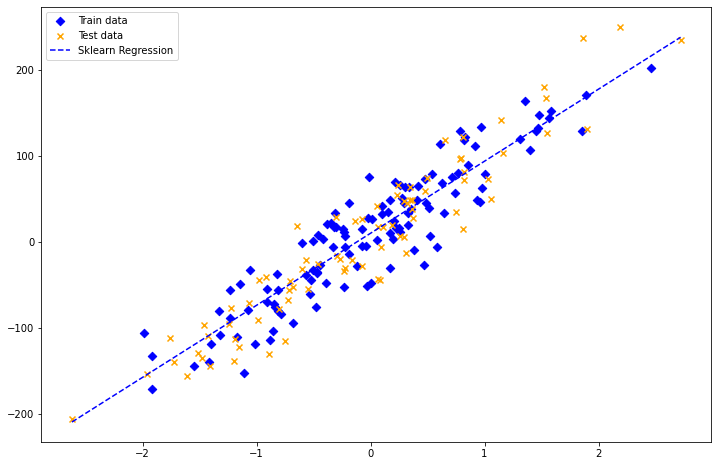

In [8]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.scatter(x_train, y_train, c="blue", marker="D", label="Train data")
ax.scatter(x_test, y_test, c="orange", marker="x", label="Test data")
ax.plot(x_test, y_pred, c="blue", marker=None, linestyle="dashed", label="Sklearn Regression")
ax.legend()
display(fig)

### Calibrate the model for quantization using both training and test data


In [9]:
calib_data = X
q_linreg = QuantizedLinearRegression.from_sklearn(linreg, calib_data)

### Now, we can compile our model to FHE, taking as the possible input set all of our dataset.

In [10]:
X_q = q_linreg.quantize_input(X)

engine = q_linreg.compile(X_q)

### Time to make some predictions, first in the clear.

In [11]:
# Now that the model is quantized, predict on the test set
x_test_q = q_linreg.quantize_input(x_test)
q_y_pred = q_linreg.forward_and_dequant(x_test_q)

### Now let's predict using the quantized FHE classifier.

In [12]:
# Now predict using the FHE quantized model on the testing set
y_test_pred_fhe = np.zeros_like(x_test)

for i, x_i in enumerate(tqdm(x_test_q.qvalues)):
    q_sample = np.expand_dims(x_i, 1).transpose([1, 0]).astype(np.uint8)
    # bench: Measure: Evaluation Time (ms)
    q_pred_fhe = engine.run(q_sample)
    y_test_pred_fhe[i] = q_linreg.dequantize_output(q_pred_fhe)
    # bench: Measure: End

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:30<00:00,  2.63it/s]


### Evaluate all versions of the classifier.

In [13]:
# Measure the error for the three versions of the classifier
sklearn_r2 = r2_score(y_pred, y_test)
non_homomorphic_test_error = r2_score(q_y_pred, y_test)
homomorphic_test_error = r2_score(y_test_pred_fhe, y_test)

# Measure the error of the FHE quantized model w.r.t the clear quantized model
difference = (
    abs(homomorphic_test_error - non_homomorphic_test_error) * 100 / non_homomorphic_test_error
)


print(f"Sklearn R^2: {sklearn_r2:.4f}")
print(f"Non Homomorphic R^2: {non_homomorphic_test_error:.4f}")
print(f"Homomorphic R^2: {homomorphic_test_error:.4f}")
print(f"Relative Difference Percentage: {difference:.2f}%")

Sklearn R^2: 0.8758
Non Homomorphic R^2: 0.8735
Homomorphic R^2: 0.8735
Relative Difference Percentage: 0.00%


### Plot the results of both the original and FHE versions of the classifier.

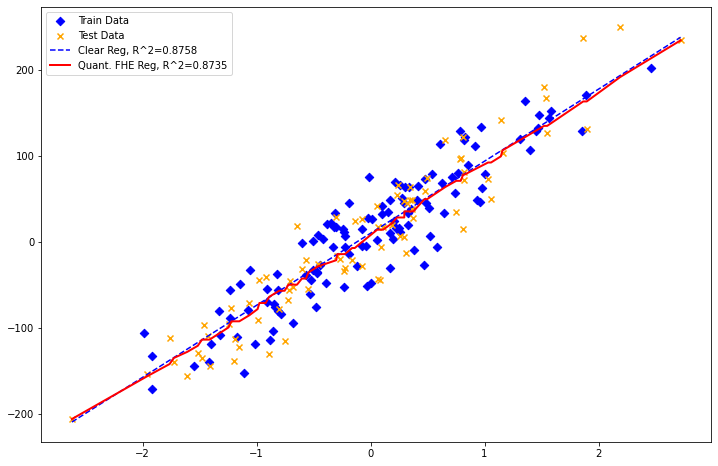

In [14]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
s1 = ax.scatter(x_train, y_train, c="blue", marker="D")
s2 = ax.scatter(x_test, y_test, c="orange", marker="x")
p1 = ax.plot(x_test, y_pred, c="blue", marker=None, linestyle="dashed")
p2 = ax.plot(x_test, y_test_pred_fhe, c="red", marker=None, linewidth=2)
ax.legend(
    [s1, s2, p1[0], p2[0]],
    [
        "Train Data",
        "Test Data",
        f"Clear Reg, R^2={sklearn_r2:.4f}",
        f"Quant. FHE Reg, R^2={homomorphic_test_error:.4f}",
    ],
)
display(fig)

### Enjoy!